# Testing the SEISCOPE optimization toolbox wrapper on the Rosenbrock function


## Problem definition


In this notebook we show how to use the `sobt-wrapper` to help compute the minimum of the non-convex bivariate Rosenbrock function

$$
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,
$$

The global minimum is inside a long, narrow, parabolic-shaped flat valley at $x=y=1$. To find the valley is trivial. To converge to the global minimum, however, is difficult. Hence, this function represents a good testing case for any non-linear optimization scheme.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from ctypes import c_int, c_float, c_bool

The SEISCOPE optimization toolbox provides four different optimization schemes: the steepest-
descent, nonlinear conjugate gradient, l-BFGS, and truncated Newton methods. Here we test the steppest-descent `PSTD` and Truncated Newton `TRN` approaches. Below, we define the Rosenbrock function which returns the function value as well as the partial derivatives with respect to the variables to be minimized.

In [2]:
def rosenbrock(X):
    """
    http://en.wikipedia.org/wiki/Rosenbrock_function
    A generalized implementation is available
    as the scipy.optimize.rosen function
    """
    a = 1. - X[0]
    b = X[1] - X[0]*X[0]
    return a*a + b*b*100., np.array([-a*2. - 400.*X[0]*b, 200.*b], dtype=np.float32)

A function that computes the action of Hessian operator on a given vector, which is required for the `TRN` method, 
along with a function to get the content of an ASCII file are also defined

In [3]:
def Hessian_Rosenbrock(X, d):
    Hd1 = (-400*X[1] + 1200*X[0]**2 + 2)*d[0] -400*X[0]*d[1]
    Hd2 = -400*X[0]*d[0] + 200*d[1]
    return np.array([Hd1, Hd2], dtype=np.float32)


def file_get_contents(filename):
    with open(filename) as f:
        return f.read()

Having defined our functions, it is now time to see the `sotb-wrapper` usage! First, we need to instantiate an object of type `sotb_wrapper`

In [4]:
# Create an instance of the SEISCOPE optimization toolbox wrapper (sotb_wrapper) Class.
import pathmagic  
from interface import sotb_wrapper, UserDefined
sotb = sotb_wrapper()

then, we set the dimension `n` of the minimization problem and the `flag` variable -  responsible for the communication with the minimization routine. This last variable has to be set to `0` in order to perform the necessary initializations in Fortran land, specifically, an initialization routine inherent to each algorithm is called in the first call of the algorithm routine within the optimization loop. On the other hand, it is necessary to set some fields in the data structure `udf` of the `sotb` object. Note the use of C datatypes like `c_int`, `c_float`, etc.

In [5]:
# Set some fields of the UserDefined derived type in Fortran
# (ctype structure) - parameter initialization
n = c_int(2)                     # dimension
flag = c_int(0)                  # first flag; 0 means initialization

# Create the dict for generate the ctypes structure
udf = {}
udf['conv'] = c_float(1e-8)    # tolerance for the stopping criterion
udf['print_flag'] = c_int(1)   # print info in output files
udf['debug'] = c_bool(False)   # level of details for output files
udf['niter_max'] = c_int(10000)  # maximum iteration number
udf['nls_max'] = c_int(30)     # max number of linesearch iteration

sotb.udf = UserDefined(**udf)

we can see the parameters setting with a simple `print`

In [6]:
print(sotb.udf)

UserDefined(debug=False, threshold=0.0, print_flag=1, first_ls=False, task=0, nls_max=30, cpt_ls=0, nfwd_pb=0, cpt_iter=0, niter_max=10000, f0=0.0, fk=0.0, conv=9.99999993922529e-09, m1=0.0, m2=0.0, mult_factor=0.0, alpha_L=0.0, alpha_R=0.0, alpha=0.0, q0=0.0, q=0.0, cpt_lbfgs=0, l=0,conv_CG=False,cpt_iter_CG=0,niter_max_CG=0,nhess=0,CG_phase=0,comm=0,qk_CG=0.0,qkm1_CG=0.0,hessian_term=0.0,eta=0.0,norm_grad=0.0,norm_grad_m1_CG=0.0,norm_residual=0.0,dHd=0.0,res_scal_respreco=0.0,alpha_CG=0.0)


Now we define a starting point at $x=y=-1$ and compute the function value and gradient for it, since they are required by the minimization function

In [7]:
# intial guess
X = np.ones(2, dtype=np.float32)*-1.
# computation of the cost and gradient associated
# with the initial guess
fcost, grad = rosenbrock(X)

The steepest-descent function supports preconditioning and the user is required to provide the preconditioned gradient if there is one. In this test a preconditioner is not available and, thereby, the input parameter `grad_preco` is the gradient itself 

In [8]:
# copy of grad in grad_preco: no preconditioning in
# this test
grad_preco = np.copy(grad)

Finally, the optimization loop is defined according to the examples provided in the Fortran package. It stops as soon as `flag` is set to `2` or to `4`, which refer respectively to the convergence of the minimization process and the failure in the line-search process. We stored all of the intermediate steps so we can see the path that algorithm takes in looking for the solution. In order to achieve this, we based on `flag` value of `3` that indicates that a new descent direction is computed. Note that the `flag` value of `1` means that the line-search process is not terminated, and a new value of the objective function and its gradient are required to continue the
line-search process. 

In [9]:
iter_x, iter_y = np.empty(0), np.empty(0)
iter_x = np.append(iter_x, X[0])
iter_y = np.append(iter_y, X[1])

# optimization loop: while convergence not reached or
# linesearch not failed, iterate
while (flag.value != 2 and flag.value != 4):
    sotb.PSTD(n, X, c_float(fcost), grad, grad_preco, flag)
    if flag.value == 3:
        iter_x = np.append(iter_x, X[0])
        iter_y = np.append(iter_y, X[1])
    if flag.value == 1:
        # compute cost and gradient at point x
        fcost, grad = rosenbrock(X)
        # no preconditioning in this test: simply copy grad in
        # grad_preco
        grad_preco = np.copy(grad)

Here is its output:

In [10]:
print('FINAL iterate is : ', X)

FINAL iterate is :  [0.99799186 0.9959825 ]


In [11]:
print(file_get_contents('iterate_ST.dat'))

**********************************************************************
              STEEEPEST DESCENT ALGORITHM         
**********************************************************************
     Convergence criterion  :   1.00E-08
     Niter_max              :   10000
     Initial cost is        :   4.04E+02
     Initial norm_grad is   :   8.98E+02
**********************************************************************
   Niter     fk        ||gk||      fk/f0       alpha       nls     ngrad    
     0    4.04E+02    8.98E+02    1.00E+00    1.00E+00       0       0
     1    2.98E+01    1.64E+02    7.37E-02    1.95E-03       9      10
     2    1.77E+00    2.68E+01    4.38E-03    1.95E-03       0      11
     3    7.67E-01    1.17E+01    1.90E-03    1.95E-03       0      12
     4    5.70E-01    5.55E+00    1.41E-03    1.95E-03       0      13
     5    5.25E-01    2.85E+00    1.30E-03    1.95E-03       0      14
     6    5.12E-01    1.74E+00    1.27E-03    1.95E-03       0      15
 

We can plot the Rosenbrock function and the Gradient Descent iteration steps

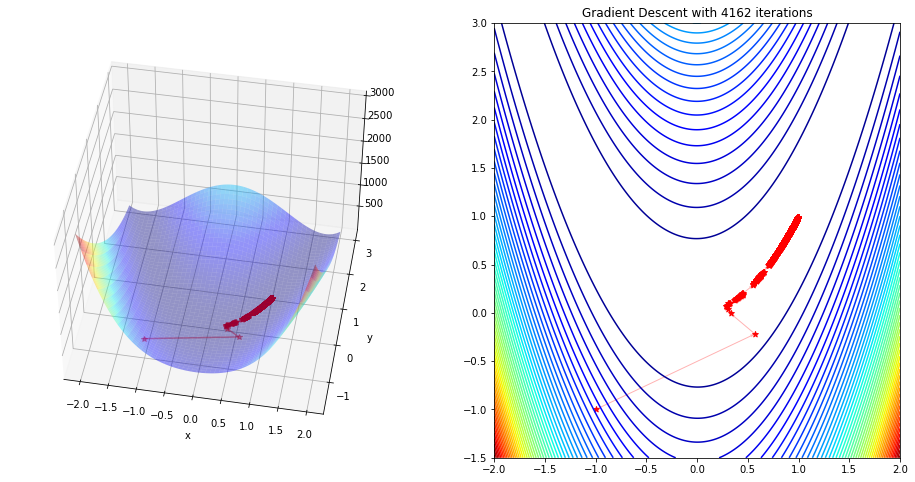

In [12]:
#NBVAL_IGNORE_OUTPUT

# Define x, y
x = np.linspace(-2, 2, 250)
y = np.linspace(-1.5, 3, 250)

# Generate grid data
X, Y = np.meshgrid(x, y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (1.-X)**2 + 100.*(Y-X*X)**2

anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, rosenbrock(np.array([iter_x,iter_y]))[0],color = 'r', marker = '*', alpha = .4)

ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Gradient Descent with {} iterations'.format(sotb.udf.cpt_iter))

plt.show()

In [13]:
print(sotb.udf)

UserDefined(debug=False, threshold=0.0, print_flag=1, first_ls=True, task=0, nls_max=20, cpt_ls=0, nfwd_pb=4841, cpt_iter=4162, niter_max=10000, f0=404.0, fk=4.041891315864632e-06, conv=9.99999993922529e-09, m1=9.999999747378752e-05, m2=0.8999999761581421, mult_factor=10.0, alpha_L=0.0, alpha_R=0.0, alpha=0.0020029728766530752, q0=-4.874219484918285e-06, q=-1.6361800589947961e-06, cpt_lbfgs=0, l=0,conv_CG=False,cpt_iter_CG=0,niter_max_CG=0,nhess=0,CG_phase=0,comm=0,qk_CG=0.0,qkm1_CG=0.0,hessian_term=0.0,eta=0.0,norm_grad=0.0,norm_grad_m1_CG=0.0,norm_residual=0.0,dHd=0.0,res_scal_respreco=0.0,alpha_CG=0.0)


Now we test the Truncated Newton function `TRN`. First, we need to reset all settings

In [14]:
# Create the dict for generate the ctypes structure
udf = {}
udf['conv'] = c_float(1e-8)    # tolerance for the stopping criterion
udf['print_flag'] = c_int(1)   # print info in output files
udf['debug'] = c_bool(False)   # level of details for output files
udf['niter_max'] = c_int(200)  # maximum iteration number
udf['nls_max'] = c_int(30)     # max number of linesearch iteration
udf['niter_max_CG'] = c_int(5) # max no. of inner CG iterations

#sotb.udf.niter_max = c_int(200)
sotb.udf = UserDefined(**udf)
print(sotb.udf)

UserDefined(debug=False, threshold=0.0, print_flag=1, first_ls=False, task=0, nls_max=30, cpt_ls=0, nfwd_pb=0, cpt_iter=0, niter_max=200, f0=0.0, fk=0.0, conv=9.99999993922529e-09, m1=0.0, m2=0.0, mult_factor=0.0, alpha_L=0.0, alpha_R=0.0, alpha=0.0, q0=0.0, q=0.0, cpt_lbfgs=0, l=0,conv_CG=False,cpt_iter_CG=0,niter_max_CG=5,nhess=0,CG_phase=0,comm=0,qk_CG=0.0,qkm1_CG=0.0,hessian_term=0.0,eta=0.0,norm_grad=0.0,norm_grad_m1_CG=0.0,norm_residual=0.0,dHd=0.0,res_scal_respreco=0.0,alpha_CG=0.0)


In addition to the gradient and value of the objective function, the `TRN` function needs the `d` and `Hd` arrays, so they are defined below

In [15]:
d = np.zeros(n.value, dtype=np.float32)
Hd = np.zeros(n.value, dtype=np.float32)

Again, we define a starting point at $x=y=-1$ and compute the function value and gradient for it.

In [16]:
X = np.ones(2, dtype=np.float32)*-1.
fcost, grad = rosenbrock(X)

The `flag` also has to be initialized to `0`.

In [17]:
flag = c_int(0)  # first flag; 0 means initialization

As in the previous case, we define the optimization loop. There is, however, a difference between this test and the last one -- the truncated Newton method (with and without preconditioning) requires the computation of Hessian-vector products as indicated by the `flag` value of `7`

In [18]:
iter_x, iter_y = np.empty(0),np.empty(0)
iter_x = np.append(iter_x,X[0])
iter_y = np.append(iter_y,X[1])

# optimization loop: while convergence not reached or
# linesearch not failed, iterate
while (flag.value != 2 and flag.value != 4):
    sotb.TRN(n, X, c_float(fcost), grad, d, Hd, flag)
    if flag.value == 3:
        iter_x = np.append(iter_x, X[0])
        iter_y = np.append(iter_y, X[1])
    if (flag.value == 1):
        # compute cost and gradient at point x
        fcost, grad = rosenbrock(X)
    elif (flag.value == 7):
        # compute d by the Hessian operator and store in Hd
        Hd = Hessian_Rosenbrock(X, d)

This is the result:

In [19]:
print('FINAL iterate is : ', X)

FINAL iterate is :  [0.9981932 0.9963789]


In [20]:
print(file_get_contents('iterate_TRN.dat'))

******************************************************************************************
                                 TRUNCATED NEWTON ALGORITHM           
******************************************************************************************
     Convergence criterion  :   1.00E-08
     Niter_max              :     200
     Initial cost is        :   4.04E+02
     Initial norm_grad is   :   8.98E+02
     Maximum CG iter        :       5
******************************************************************************************
   Niter     fk        ||gk||      fk/f0       alpha        nls   nit_CG    eta      ngrad    nhess 
     0    4.04E+02    8.98E+02    1.00E+00    1.00E+00       0       0    9.00E-01       0       0
     1    1.06E+02    2.93E+02    2.62E-01    1.00E+00       0       1    9.00E-01       2       1
     2    2.23E+01    9.75E+01    5.52E-02    1.00E+00       0       1    8.43E-01       3       2
     3    1.39E+00    1.16E+01    3.43E-03    1.00E+00     

We can also plot the Truncated Newton iteration steps

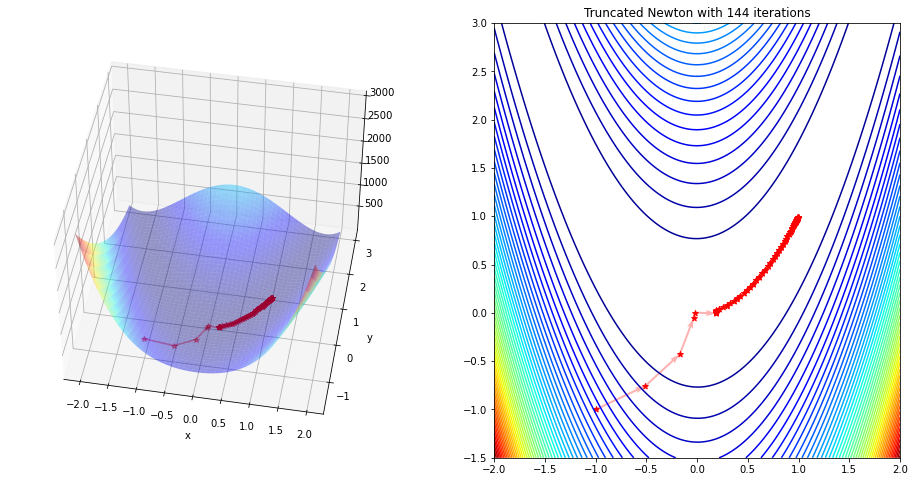

In [21]:
#NBVAL_IGNORE_OUTPUT

# Define x, y
x = np.linspace(-2, 2, 250)
y = np.linspace(-1.5, 3, 250)

# Generate grid data
X, Y = np.meshgrid(x, y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (1.-X)**2 + 100.*(Y-X*X)**2

anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, rosenbrock(np.array([iter_x,iter_y]))[0],color = 'r', marker = '*', alpha = .4)

ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Truncated Newton with {} iterations'.format(sotb.udf.cpt_iter))

plt.show()

## Adding Bounds and More Output

We can print out more detailed information about the minimization using the `debug` variable. To do this, we need to switch it to `True`, i.e., `udf['debug'] = c_bool(True)`:

In [22]:
# Create the dict for generate the ctypes structure
udf = {}
udf['conv'] = c_float(1e-8)    # tolerance for the stopping criterion
udf['print_flag'] = c_int(1)   # print info in output files
udf['debug'] = c_bool(True)   # level of details for output files
udf['niter_max'] = c_int(200)  # maximum iteration number
udf['nls_max'] = c_int(30)     # max number of linesearch iteration
udf['niter_max_CG'] = c_int(5) # max no. of inner CG iterations

sotb.udf = UserDefined(**udf)

We can also extend the above script to add constraints. To do this, we define the lower and upper bounds arrays. Then, we only need to specify these arrays for the `lb` and `ub` optional arguments when the `TRN` function is called.

In [23]:
# Box contraints
ubounds = np.array([0.5, 1.0], dtype=np.float32)
lbounds = np.array([-1.2, -1.2], dtype=np.float32)

Once again, we set the `d`, `Hd` arrays, as well as the `flag` value and the starting point `X` and compute
the function value and gradient for this point as we did it before. The optimization loop remains the same - the only difference being the calling of the `TRN` function with values for the `lb` and `ub` arguments

In [24]:
d = np.zeros(n.value, dtype=np.float32)
Hd = np.zeros(n.value, dtype=np.float32)

X = np.ones(2, dtype=np.float32)*-1.
fcost, grad = rosenbrock(X)

flag = c_int(0)  # first flag; 0 means initialization

iter_x, iter_y = np.empty(0),np.empty(0)
iter_x = np.append(iter_x,X[0])
iter_y = np.append(iter_y,X[1])

# optimization loop: while convergence not reached or
# linesearch not failed, iterate
while (flag.value != 2 and flag.value != 4):
    sotb.TRN(n, X, c_float(fcost), grad, d, Hd, flag, lb=lbounds, ub=ubounds)
    if flag.value == 3:
        iter_x = np.append(iter_x, X[0])
        iter_y = np.append(iter_y, X[1])
    if (flag.value == 1):
        # compute cost and gradient at point x
        fcost, grad = rosenbrock(X)
    elif (flag.value == 7):
        # compute d by the Hessian operator and store in Hd
        Hd = Hessian_Rosenbrock(X, d)

In [25]:
print('FINAL iterate is : ', X)

FINAL iterate is :  [0.5        0.25023577]


This time, further information on the minimization process is provided by the log file

In [26]:
print(file_get_contents('iterate_TRN.dat'))

******************************************************************************************
                                 TRUNCATED NEWTON ALGORITHM           
******************************************************************************************
     Convergence criterion  :   1.00E-08
     Niter_max              :     200
     Initial cost is        :   4.04E+02
     Initial norm_grad is   :   8.98E+02
     Maximum CG iter        :       5
******************************************************************************************
   Niter     fk        ||gk||      fk/f0       alpha        nls   nit_CG    eta      ngrad    nhess 
     0    4.04E+02    8.98E+02    1.00E+00    1.00E+00       0       0    9.00E-01       0       0
 fcost :   105.761673    
 optim%f0 :   404.000000    
 optim%fk :   404.000000    
 optim%alpha :   1.00000000    
 optim%q :  -152.692871    
 optim%q0 :  -490.857361    
 m1 :   9.99999975E-05
 cpt_ls is :            0
     1    1.06E+02    2.93E+02    2

Plotting the Truncated Newton iteration steps we check that it correctly finds the solution to the constrained problem, that is, the closest feasible minimum point.

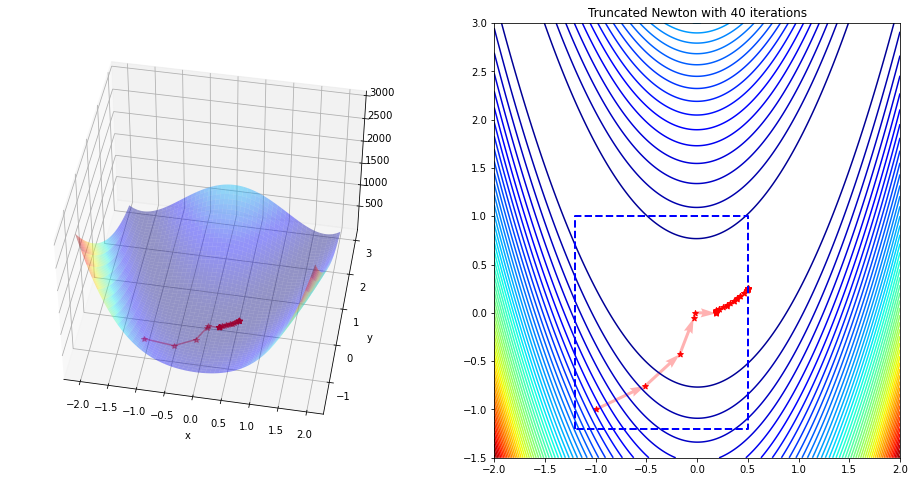

In [27]:
#NBVAL_IGNORE_OUTPUT

# Define x, y
x = np.linspace(-2, 2, 250)
y = np.linspace(-1.5, 3, 250)

# Generate grid data
X, Y = np.meshgrid(x, y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (1.-X)**2 + 100.*(Y-X*X)**2

bounds_points_x = np.array([lbounds[0],lbounds[0],ubounds[0],ubounds[0],lbounds[0]])
bounds_points_y = np.array([lbounds[1],ubounds[1],ubounds[1],lbounds[1],lbounds[1]])

anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, rosenbrock(np.array([iter_x,iter_y]))[0],color = 'r', marker = '*', alpha = .4)

ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.plot(bounds_points_x, bounds_points_y, "--", color='b', linewidth=2)
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Truncated Newton with {} iterations'.format(sotb.udf.cpt_iter))

plt.show()